# Training & Evaluation of Several Filters

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier
import time
from math import sqrt
from sklearn.externals import joblib
from os.path import join

/Users/nicochaves/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/nicochaves/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/nicochaves/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.

In [2]:
### Set Relevant Paths

In [3]:
data_dir = '../../data'
saved_models_dir = 'saved_models'

## Load Training and Test Data

In [4]:
file_dir = join(data_dir,'processed/chrom20')
filename = 'NA12878.LowSeq.illumina.bwa.sorted.dedup.20.sam.wFlag.qual.recalibrated.filtered.noNAN.scaled.withGndTruthLabels'
train_file = join(file_dir, filename + '.train.table')
test_file = join(file_dir, filename + '.test.table')

df_train_full = pd.read_csv(train_file, sep='\t') # training and dev sets combined
df_test = pd.read_csv(test_file, sep='\t')

In [5]:
print 'Features (some of these may get taken out): ', df_train_full.columns
print '# training examples: ', df_train_full.shape[0]
print '# test examples: ', df_test.shape[0]

Features (some of these may get taken out):  Index([u'Unnamed: 0', u'QUAL', u'AC', u'AF', u'DP', u'FS', u'MLEAC', u'MLEAF',
       u'MQ', u'QD', u'SOR', u'sample1.DP', u'sample1.GQ',
       u'POSITIVE_TRAIN_SITE', u'DB', u'FILTER', u'GROUND_TRUTH'],
      dtype='object')
# training examples:  60790
# test examples:  26053


In [6]:
df_train_full = df_train_full.drop('Unnamed: 0', axis=1)  
df_test = df_test.drop('Unnamed: 0', axis=1)

## Split train into train and dev, and split into X and Y

In [7]:
num_train = df_train_full.shape[0]
idx_train_dev = train_test_split(range(num_train), range(num_train), test_size = 0.3, random_state=0)
idx_train = idx_train_dev[0]
idx_dev = idx_train_dev[1]

In [8]:
df_train = df_train_full.loc[idx_train,:]
df_dev = df_train_full.loc[idx_dev,:]

df_train_Y = df_train['GROUND_TRUTH']
df_train_X = df_train.drop(['GROUND_TRUTH'], axis=1)

df_dev_Y = df_dev['GROUND_TRUTH']
df_dev_X = df_dev.drop(['GROUND_TRUTH'], axis=1)

df_test_Y = df_test['GROUND_TRUTH']
df_test_X = df_test.drop(['GROUND_TRUTH'], axis=1)

df_train_full_Y = df_train_full['GROUND_TRUTH']
df_train_full_X = df_train_full.drop(['GROUND_TRUTH'], axis=1)

# Evaluate VQSR Performance

In [9]:
# See https://software.broadinstitute.org/gatk/guide/article?id=39 for interpretation of tranche labels

LOW_QUAL = 'LowQual'
TRANCHE_99_9 = 'VQSRTrancheSNP99.90to100.00' # if you ignore these and the above, you recover at most 99.9% of all variants. has some low vqslod values
TRANCHE_99 = 'VQSRTrancheSNP99.00to99.90' # if you retain these and ignore the above, you'll recover at most 99% of variants. 
PASS_ALL = 'PASS'  # if you **retain** these and ignore the above, you'll recover at most 90% of the variants

def did_variant_pass_filter(label, tranche):
    return label == PASS_ALL or \
            (tranche == TRANCHE_99 and label == TRANCHE_99) or \
            (tranche == TRANCHE_99_9 and (label == TRANCHE_99 or label == TRANCHE_99_9))
            
def convert_vqsr_labels(raw_labels, tranche=None):
    num_labels = raw_labels.shape[0]
    labels = num_labels * [0]
    for i, label in enumerate(raw_labels):
        if did_variant_pass_filter(label, tranche):
            labels[i] = 1
    return labels        

In [10]:
vqsr_dev_labels = df_dev_X['FILTER']
vqsr_test_labels = df_test_X['FILTER']
vqsr_tranches_uniq = set(df_dev_X['FILTER'])

if LOW_QUAL in vqsr_tranches_uniq:
    vqsr_tranches_uniq -= {LOW_QUAL}

vqsr_tranches_uniq = list(vqsr_tranches_uniq)    

vqsr_prec = np.zeros(len(vqsr_tranches_uniq))
vqsr_recall = np.zeros(len(vqsr_tranches_uniq))
vqsr_f1 = np.zeros(len(vqsr_tranches_uniq))

for i, tranche in enumerate(vqsr_tranches_uniq):
    print 'Tranche: ', tranche
    vqsr_dev_labels_binary = convert_vqsr_labels(vqsr_dev_labels, tranche)
    vqsr_dev_acc = accuracy_score(df_dev_Y, vqsr_dev_labels_binary)
    print 'VQSR Dev Accuracy: ', vqsr_dev_acc
    vqsr_test_labels_binary = convert_vqsr_labels(vqsr_test_labels, tranche)
    vqsr_test_acc = accuracy_score(df_test_Y, vqsr_test_labels_binary)
    print 'VQSR Test Accuracy: ', vqsr_test_acc
    
    vqsr_prec[i] = precision_score(df_test_Y, vqsr_test_labels_binary)
    vqsr_recall[i] = recall_score(df_test_Y, vqsr_test_labels_binary)
    print 'Precision: ', vqsr_prec[i]
    print 'Recall: ', vqsr_recall[i]
    
    
    vqsr_f1[i] = f1_score(df_test_Y, vqsr_test_labels_binary, average='weighted')  
    print 'F1 score: ', vqsr_f1[i]

Tranche:  VQSRTrancheSNP99.00to99.90
VQSR Dev Accuracy:  0.925755332566
VQSR Test Accuracy:  0.926495988946
Precision:  0.943699132457
Recall:  0.969851555678
F1 score:  0.924222890917
Tranche:  VQSRTrancheSNP99.90to100.00
VQSR Dev Accuracy:  0.838405439491
VQSR Test Accuracy:  0.838137642498
Precision:  0.8460233549
Recall:  0.985569189761
F1 score:  0.78619962665
Tranche:  PASS
VQSR Dev Accuracy:  0.917475461973
VQSR Test Accuracy:  0.921275860745
Precision:  0.980917520742
Recall:  0.923709729307
F1 score:  0.925161085262


### TODO: Consider using VQSLOD to obtain AUC Score. Issue is that sometimes the VQSLOD is NAN

In [12]:
## Verify that the VQSR tranches worked as expected
df2 = pd.read_csv(join(data_dir, file_dir + filename + '.table'), sep='\t') # training and dev sets combined
df2.columns

Index([u'Unnamed: 0', u'QUAL', u'AC', u'AF', u'DP', u'FS', u'MLEAC', u'MLEAF',
       u'MQ', u'QD', u'SOR', u'sample1.DP', u'sample1.GQ',
       u'POSITIVE_TRAIN_SITE', u'DB', u'FILTER', u'GROUND_TRUTH'],
      dtype='object')

In [13]:
df2_pos = df2[df2['POSITIVE_TRAIN_SITE'] == 1]['FILTER']
num_pos_training_sites = df2_pos.shape[0]
print '# of positive training sites used by VQSR: ', num_pos_training_sites

# of positive training sites used by VQSR:  65506


In [14]:
numPass = df2_pos[df2_pos == 'PASS'].shape[0]
num99 = df2_pos[df2_pos == 'VQSRTrancheSNP99.00to99.90'].shape[0]
num99_9 = df2_pos[df2_pos == 'VQSRTrancheSNP99.90to100.00'].shape[0]
numLowQual = df2_pos[df2_pos == 'LowQual'].shape[0]

print '# PASS: ', numPass, ' or ', 100.0*numPass/num_pos_training_sites, '%'
print '# VQSRTrancheSNP99.00to99.90: ', num99, ' or ', 100.0*num99/num_pos_training_sites, '%'
print '# VQSRTrancheSNP99.90to100.0: ', num99_9, ' or ', 100.0*num99_9/num_pos_training_sites, '%'
print '# LowQual: ', numLowQual

# PASS:  63459  or  96.8750954111 %
# VQSRTrancheSNP99.00to99.90:  1904  or  2.90660397521 %
# VQSRTrancheSNP99.90to100.0:  143  or  0.218300613684 %
# LowQual:  0


In [15]:
96.8750954111+ 2.90660397521

99.78169938631001

### It appears that VQSR rounds the VQSLOD thresholds because these sensitivities are not extremely close to the advertised levels. 

## Remove VQSR Filter label so that we can run non-VQSR methods

In [16]:
df_train_X = df_train_X.drop(['FILTER'], axis=1)
df_dev_X = df_dev_X.drop(['FILTER'], axis=1)
df_train_full_X = df_train_full_X.drop(['FILTER'], axis=1)
df_test_X = df_test_X.drop(['FILTER'], axis=1)

# Supervised Learning Approaches

In [17]:
# Number of folds for cross validation
num_folds = 5

# Loss function to use. Must be either 'l1' or 'l2'
loss_function = 'l2'  

In [18]:
def f1_prec_recall(pred, labels, verbose=True):
    f1 = f1_score(pred, labels, average='binary')
    prec = precision_score(pred, labels)
    recall = recall_score(pred, labels)
    
    if verbose:
        # Make a Pandas DataFrame to print results more nicely
        df = pd.DataFrame(data=np.asarray([[f1, prec, recall]]),
                         columns=['F1', 'Precision', 'Recall'])
        print df.to_string(index=False, justify='left')
        
    return f1, prec, recall

## Logistic Regression

In [19]:
lr_start = time.clock()

lr_params = {'C':np.logspace(-3, 5, 20)}
lr_obj = linear_model.LogisticRegression(penalty=loss_function, random_state=0)

# Note: GridSearchCV will automatically use Stratified k-fold CV if the labels are binary and 
# the 'cv' parameter is an int
lr_classifier = GridSearchCV(lr_obj, lr_params, cv=num_folds, scoring='f1')
lr_classifier.fit(df_train_X, df_train_Y)

lr_stop = time.clock()
lr_time_train = lr_stop - lr_start

print 'Logistic Regression CV Time (in seconds): ', lr_time_train

Logistic Regression CV Time (in seconds):  29.245917


In [20]:
# Save the classifier
joblib.dump(lr_classifier, join(saved_models_dir,'lr_classifier'))

['saved_models/lr_classifier']

In [ ]:
# Load the saved classifier
lr_classifier = joblib.load(join(saved_models_dir,'lr_classifier'))

In [21]:
print 'Logistic Regression Best Estimator: ', lr_classifier.best_estimator_

Logistic Regression Best Estimator:  LogisticRegression(C=5455.5947811685146, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


## Support Vector Classifier

In [28]:
svc_num_folds = 3

svc_start = time.clock()

svc_params = {'C':np.logspace(2, 4, 3), 'gamma':[0.1]}
svc_obj = SVC(kernel='rbf', random_state=0)

# Note: GridSearchCV will automatically use Stratified k-fold CV if the labels are binary and 
# the 'cv' parameter is an int
svc_classifier = GridSearchCV(svc_obj, svc_params, cv=svc_num_folds, scoring='f1')
svc_classifier.fit(df_train_X, df_train_Y)

svc_stop = time.clock()
svc_time_train = svc_stop - svc_start

print 'SVC CV Time (in seconds): ', svc_time_train

SVC CV Time (in seconds):  265.314553


In [29]:
# Save the classifier
joblib.dump(svc_classifier, join(saved_models_dir,'svc_classifier'))

['saved_models/svc_classifier']

In [ ]:
# Load the classifier
svc_classifier = joblib.load(join(saved_models_dir,'svc_classifier'))

In [30]:
print 'SVC Best Estimator: ', svc_classifier.best_estimator_

SVC Best Estimator:  SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)


In [20]:
svc_start = time.clock()

svc_params = {'C':np.logspace(0, 3, 5), 'gamma':[0.05, 0.1]}
svc_obj = SVC(kernel='rbf', random_state=0)

# Note: GridSearchCV will automatically use Stratified k-fold CV if the labels are binary and 
# the 'cv' parameter is an int
svc_classifier = GridSearchCV(svc_obj, svc_params, cv=num_folds)
svc_classifier.fit(df_train_X, df_train_Y)

svc_stop = time.clock()
svc_time_train = svc_stop - svc_start

print 'SVC CV Time (in seconds): ', svc_time_train

SVC CV Time (in seconds):  1520.217525


In [21]:
svc_best_est = svc_classifier.best_estimator_
print 'SVC Best Score: ', svc_classifier.best_score_
print 'SVC Best Estimator: ', svc_best_est
svc_dev_score = svc_classifier.score(df_dev_X, df_dev_Y)
print 'SVC Score on Dev Set: ', svc_dev_score

SVC Best Score:  0.961741827838
SVC Best Estimator:  SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC Score on Dev Set:  0.960300488019


## Random Forest Classifier

In [24]:
num_features = df_train_X.shape[1]

rf_start = time.clock()

# Use 20 trees in the forest (if you have the time or resources, consider using more trees)
# However, I've tried up to 50 trees and it makes very little difference on dev set error
rf_params = {"n_estimators":[20], 
             "criterion": ["gini", "entropy"], 
             "max_features": range(int(sqrt(num_features)), num_features, 2)
            }
rf_obj = RandomForestClassifier(random_state=0)

rf_classifier = GridSearchCV(rf_obj, rf_params, cv=num_folds, scoring='f1')
rf_classifier.fit(df_train_X, df_train_Y)

rf_stop = time.clock()
rf_time_train = rf_stop - rf_start

print 'Random Forest CV Time (in seconds): ', rf_time_train

Random Forest CV Time (in seconds):  116.039363


In [25]:
# Save the classifier
joblib.dump(rf_classifier, join(saved_models_dir,'rf_classifier'))

['saved_models/rf_classifier']

In [ ]:
rf_classifier = joblib.load(join(saved_models_dir,'rf_classifier'))

In [26]:
print 'Rand Forest Best Estimator: ', rf_classifier.best_estimator_

Rand Forest Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)


# Evaluate classifiers on test set. First, we need to retrain classifiers on full dataset using optimal parameters that we found above using cross validation

## Logistic Regression

In [23]:
lr_start = time.clock()

lr_classifier_full = linear_model.LogisticRegression(penalty=loss_function, C=lr_classifier.best_estimator_.C)
lr_classifier_full.fit(df_train_full_X, df_train_full_Y) 
lr_pred_test = lr_classifier_full.predict(df_test_X)

lr_stop = time.clock()
lr_time_test = lr_stop - lr_start
print 'Execution Time (in seconds): ', lr_time_test

lr_f1, lr_prec, lr_recall = f1_prec_recall(df_test_Y, lr_pred_test)  

Execution Time (in seconds):  0.639834
F1        Precision  Recall  
0.974776  0.970096   0.979503


## SVC

In [32]:
svc_start = time.clock()

svc_best_est = svc_classifier.best_estimator_
svc_classifier_full = SVC(kernel='rbf', gamma=svc_best_est.gamma, C=svc_best_est.C)
svc_classifier_full.fit(df_train_full_X, df_train_full_Y) 
svc_pred_test = svc_classifier_full.predict(df_test_X)

svc_stop = time.clock()
svc_time_test = svc_stop - svc_start
print 'Execution Time (in seconds): ', svc_time_test

svc_f1, svc_prec, svc_recall = f1_prec_recall(df_test_Y, svc_pred_test)  

Execution Time (in seconds):  183.794678
F1        Precision  Recall  
0.979253  0.972703   0.985891


## Random Forest

In [33]:
rf_start = time.clock()

rf_best_est = rf_classifier.best_estimator_
rf_model_full = RandomForestClassifier(n_estimators=rf_best_est.n_estimators, 
                                       criterion=rf_best_est.criterion,
                                       max_features=rf_best_est.max_features)
rf_model_full.fit(df_train_full_X, df_train_full_Y)
rf_pred_test = rf_model_full.predict(df_test_X)

rf_stop = time.clock()
rf_time_test = rf_stop - rf_start
print 'Execution Time (in seconds): ', rf_time_test

rf_f1, rf_prec, rf_recall = f1_prec_recall(df_test_Y, rf_pred_test)  

Execution Time (in seconds):  1.895142
F1        Precision  Recall  
0.979571  0.976307   0.982858


# Plot the Results

In [36]:
methods = ['VQSR (99%)', 'VQSR (99.9%)', 'Logistic Reg', 'SVM', 'Rand Forest']
colors = ['c', 'b', 'r', 'purple', 'g']
vqsr_tranche_idx_99 = vqsr_tranches_uniq.index(PASS_ALL)
vqsr_tranche_idx_99_9 = vqsr_tranches_uniq.index(TRANCHE_99)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

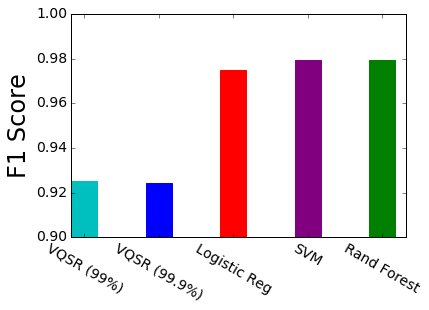

In [38]:
plt.figure()

f1s = [vqsr_f1[vqsr_tranche_idx_99], vqsr_f1[vqsr_tranche_idx_99_9], lr_f1, svc_f1, rf_f1]
ind = np.arange(len(methods))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(ind, f1s, width)
for i,c in enumerate(colors):
    rects[i].set_color(c)

ax.set_xticks(ind + width/2)
ax.set_xticklabels((methods), rotation=-30)

plt.ylim([0.9, 1.0])
plt.ylabel('F1 Score', fontsize=24)
plt.show()

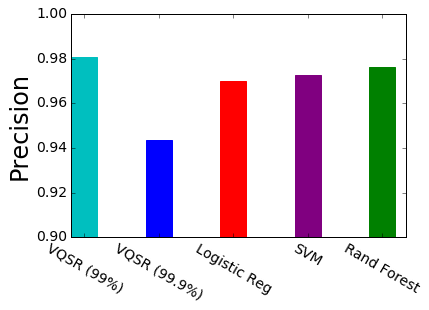

In [39]:
plt.figure()

precs = [vqsr_prec[vqsr_tranche_idx_99], vqsr_prec[vqsr_tranche_idx_99_9], lr_prec, svc_prec, rf_prec]
ind = np.arange(len(methods))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(ind, precs, width)
for i,c in enumerate(colors):
    rects[i].set_color(c)

ax.set_xticks(ind + width/2)
ax.set_xticklabels((methods), rotation=-30)

plt.ylim([0.9, 1.0])
plt.ylabel('Precision', fontsize=24)
plt.show()

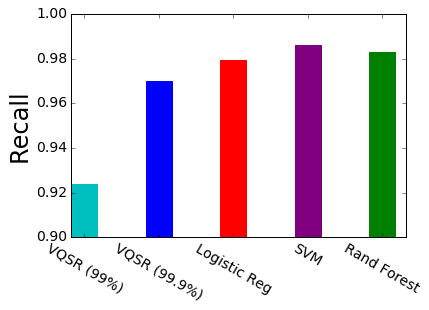

In [40]:
plt.figure()

recalls = [vqsr_recall[vqsr_tranche_idx_99], vqsr_recall[vqsr_tranche_idx_99_9], lr_recall, svc_recall, rf_recall]
ind = np.arange(len(methods))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(ind, recalls, width)
for i,c in enumerate(colors):
    rects[i].set_color(c)

ax.set_xticks(ind + width/2)
ax.set_xticklabels((methods), rotation=-30)

plt.ylim([0.9, 1.0])
plt.ylabel('Recall', fontsize=24)
plt.show()

## Total Execution Times

In [41]:
lr_total_time = lr_time_train + lr_time_test
svc_total_time = svc_time_train + svc_time_test
rf_total_time = rf_time_train + rf_time_test
print 'Total Execution Times:'
print 'Logistic Reg: ', lr_total_time
print 'SVM: ', svc_total_time
print 'Random Forest: ', rf_total_time

Total Execution Times:
Logistic Reg:  29.885751
SVM:  449.109231
Random Forest:  117.934505
